## General Info

This notebook presents an analysis of machine learning models trained to predict
heart disease using three different data preprocessing approaches. The quality of the model was evaluated on a deferred sample.
Based on this analysis, the best-performing model and preprocessing pipeline
for the task are identified.

## Table of contents

1. [General Info](#general-Info)
2. [Dataset & Preprocessing](#Dataset-&-Preprocessing)
3. [Evaluation Metrics](#Evaluation-Metrics)
4. [Results](#Results)
   - [Imports & Settings](#Imports-&-Settings)
   - [Metrics Tables](#Metrics-Tables)
   - [Confusion Matrices](#Confusion-Matrices)
   - [Bar Plot Comparison](#Bar-Plot-Comparison)
   - [Curve Analysis](#Curve-Analysis)
     - [ROC Curve](#ROC-Curve)
     - [PR Curve](#PR-Curve)
5. [Summary](#Summary)

## Dataset & Preprocessing

The dataset was previously analyzed in the exploratory data analysis (EDA) notebook.
Three preprocessing pipelines were used in this project:

**Simple pipeline**

Contains minimal processing steps:

- Rows with missing values are removed
- Outliers are filtered using a predefined threshold
- No feature scaling
- One-Hot Encoding using Pandas

**Standard pipeline**

Includes common preprocessing steps:

- Missing values are replaced with mean (for numerical) or mode (for categorical) 
- Outliers are removed based on percentiles
- One-Hot Encoding using Scikit-Learn
- Feature scaling with StandardScaler

**Advanced pipeline**

Applies more sophisticated preprocessing:

- Categorical values are encoded by frequency
- Missing values are imputed using KNNImputer
- Feature scaling with RobustScaler
- Outliers are removed using IsolationForest

Each pipeline produces a separate train-test split and corresponding trained models.

## Evaluation Metrics

The following metrics are used to evaluate models:

- **Accuracy** - the percentage of correct predictions among all samples. It provides a general overview of model performance and is reported as a supplementary metric, as it may be misleading in medical classification tasks.

- **Precision** - the proportion of correctly identified sick patients among all patients predicted as sick by the model.  
- **Recall** - the harmonic mean of Precision and Recall, with β = 2, placing greater emphasis on Recall. This choice reflects the priority of identifying as many sick patients as possible, even at the cost of increased false positives.
- **F2** - the harmonic mean of Precision and Recall. β = 2 because identifying as many sick
patients as possible is more important than avoiding false alarms.
- **ROC-AUC** - the area under the Receiver Operating Characteristic curve. This metric reflects the overall discriminative ability of the model and is used as a general performance indicator.
- **PR-AUC** - the area under the Precision–Recall curve, estimated using the Average Precision (AP) score in this analysis. This metric is particularly informative for evaluating model performance on the positive (diseased) class.

These metrics provide both a **threshold-dependent evaluation** (Accuracy, Precision, Recall,  F2, Confusion Matrix) and **threshold-independent evaluation** (ROC-AUC, PR-AUC), giving a comprehensive overview of model performance.

- All metrics values can be found in the [Metrics Tables](#Metrics-Tables) section.
- Confusion Matrices are shown in [Confusion Matrices](#Confusion-Matrices).
- ROC-AUC and PR-AUC curves are visualized in [Curve Analysis](#Curve-Analysis).

## Results

#### Imports & Settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
results_dir = Path("../results")
splits_dir = Path("../data/splits")
preprocessing_types = ['simple', 'standard', 'advanced']

#### Metrics Tables

In [3]:
simple_metrics = pd.read_csv(results_dir / 'simple_metrics.csv')
standard_metrics = pd.read_csv(results_dir / 'standard_metrics.csv')
advanced_metrics = pd.read_csv(results_dir / 'advanced_metrics.csv')

print(f'Simple: \n{simple_metrics}\n'
      f'\nStandard: \n{standard_metrics}\n'
      f'\nAdvanced: \n{advanced_metrics}\n')

Simple: 
  model  accuracy  precision    recall        f2   roc_auc
0   Ada  0.860360   0.844037  0.867925  0.863039  0.934613
1    GB  0.855856   0.836364  0.867925  0.861423  0.932336
2   KNN  0.693694   0.658333  0.745283  0.726103  0.767689
3    LR  0.869369   0.853211  0.877358  0.872420  0.931522
4    RF  0.869369   0.834783  0.905660  0.890538  0.937703
5   SVM  0.860360   0.826087  0.896226  0.881262  0.925098

Standard: 
  model  accuracy  precision    recall        f2   roc_auc
0   Ada  0.843602   0.817308  0.858586  0.850000  0.910038
1    GB  0.815166   0.819149  0.777778  0.785714  0.907828
2   KNN  0.853081   0.826923  0.868687  0.860000  0.917118
3    LR  0.876777   0.876289  0.858586  0.862069  0.931006
4    RF  0.862559   0.843137  0.868687  0.863454  0.926948
5   SVM  0.838863   0.828283  0.828283  0.828283  0.919282

Advanced: 
  model  accuracy  precision    recall        f2   roc_auc
0   Ada  0.860870   0.907407  0.816667  0.833333  0.935341
1    GB  0.856522   0.8

The key metrics are Recall, Precision, and F2, as they indicate how many patients the model correctly identifies and how accurate these predictions are.

* The highest Recall and F2 were achieved with the advanced pipeline using Random Forest (Recall = 0.9167, F2 = 0.9121).

* The lowest performance was observed with the simple pipeline using KNN (Recall = 0.7453, F2 = 0.7261).

#### Confusion Matrices

<Figure size 800x600 with 0 Axes>

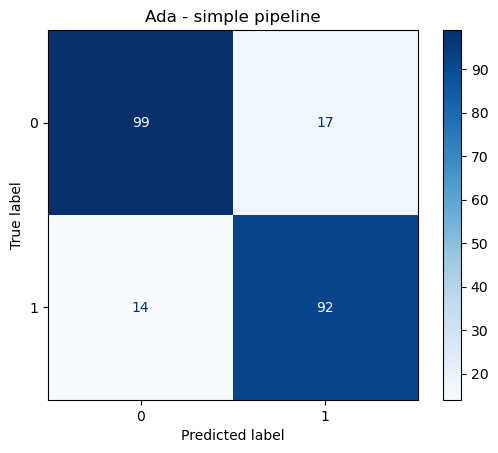

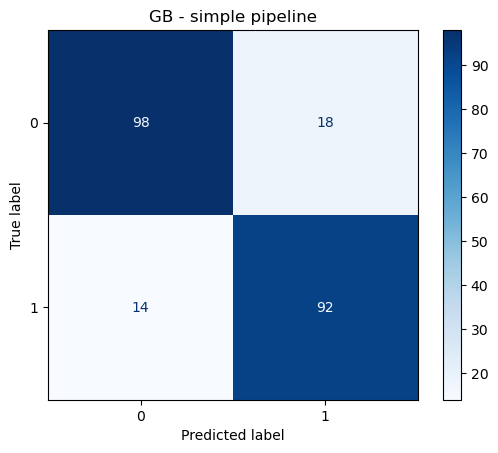

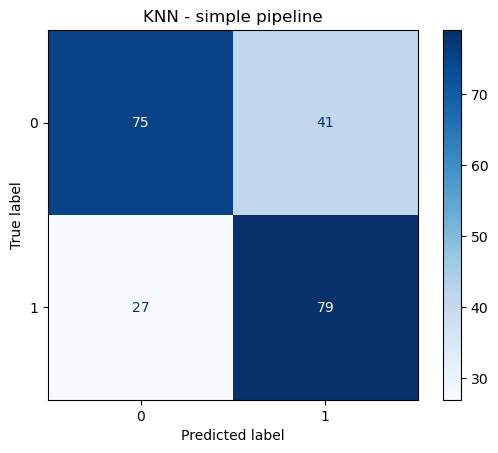

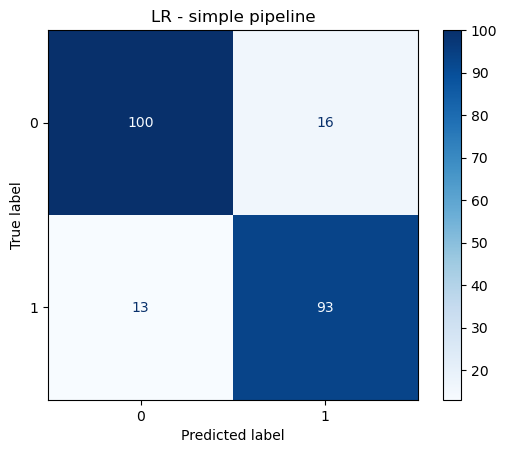

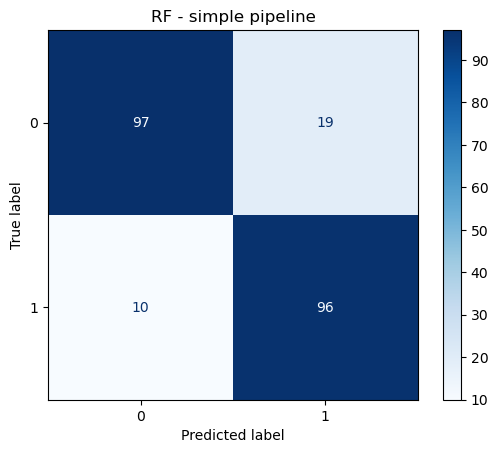

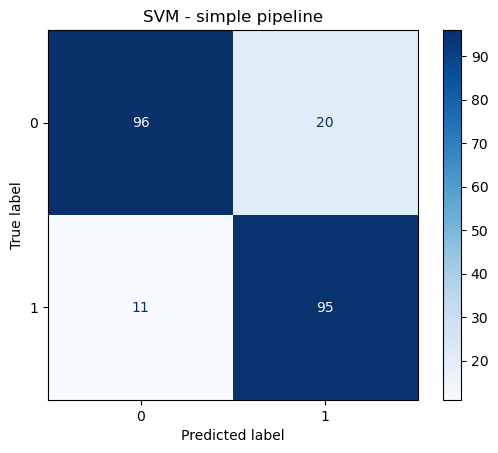

<Figure size 800x600 with 0 Axes>

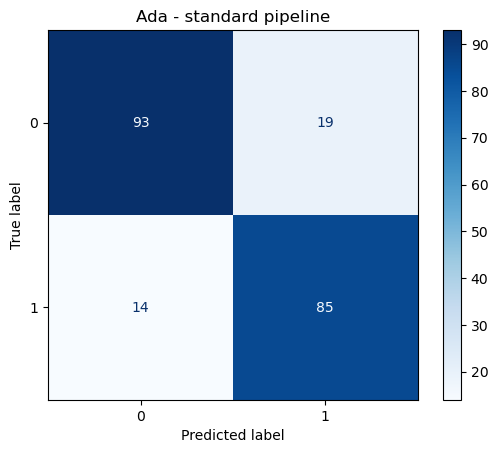

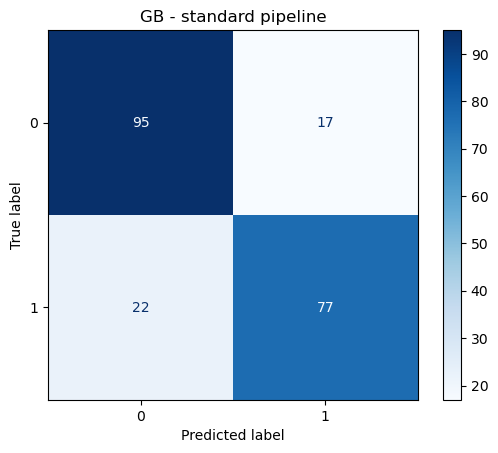

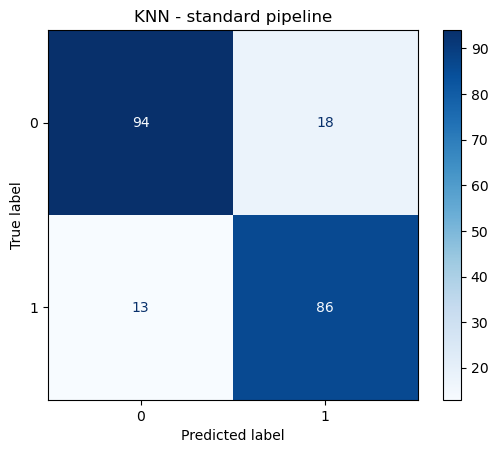

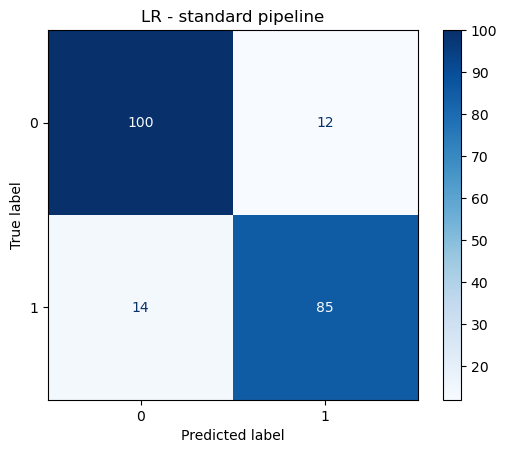

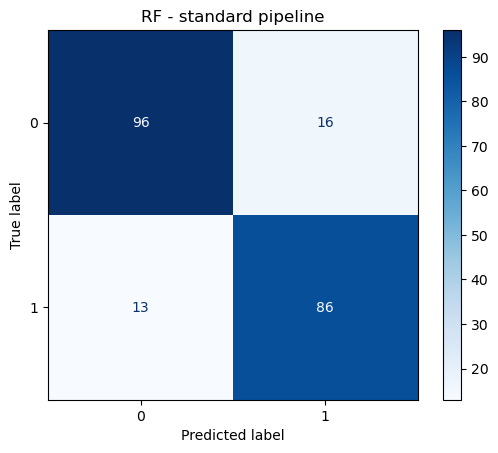

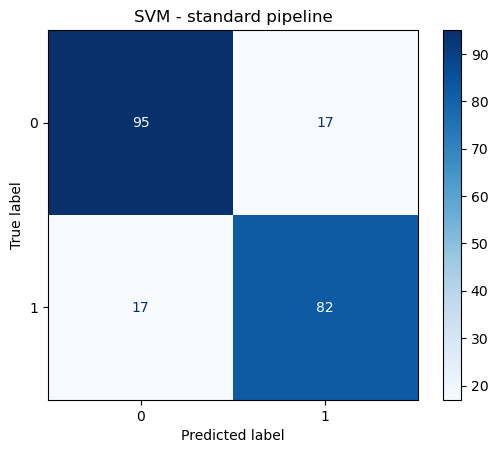

<Figure size 800x600 with 0 Axes>

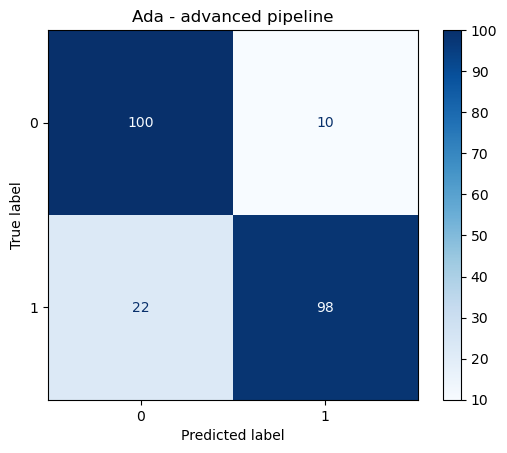

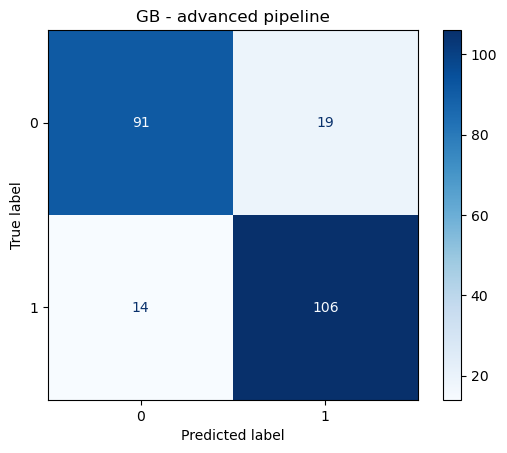

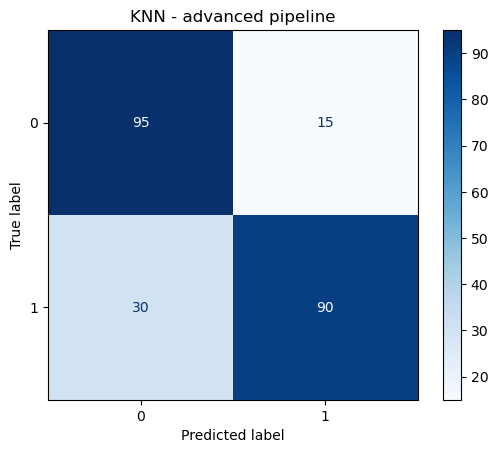

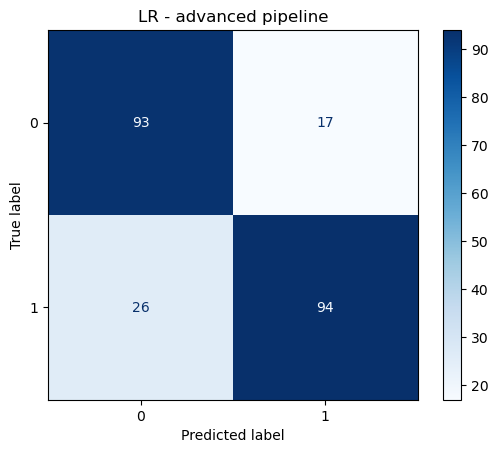

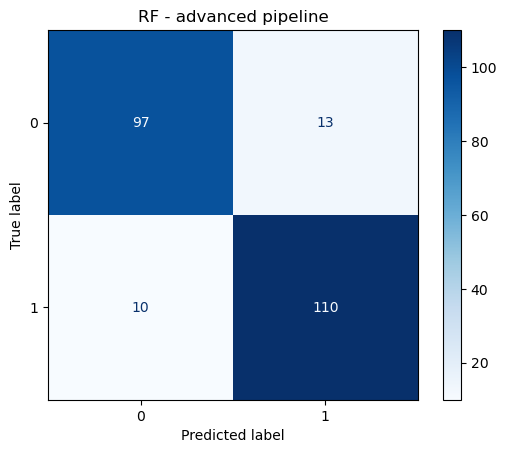

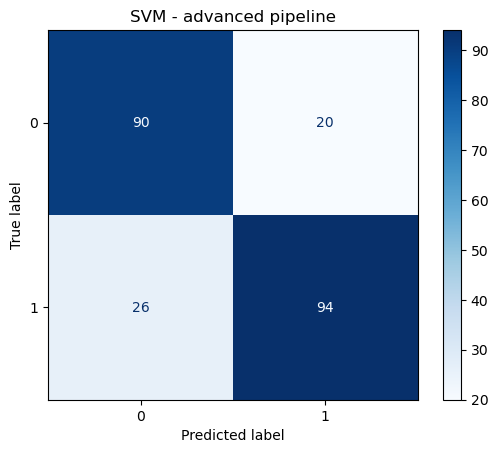

In [4]:
for prep in preprocessing_types:
    predict_file = Path(results_dir / f'{prep}_y_predict.npy')
    y_predictions = np.load(predict_file, allow_pickle=True).item()  # это словарь: model_name -> y_pred
    y_test = pd.read_csv(splits_dir / f'{prep}_y_test.csv').values.ravel()

    plt.figure(figsize=(8,6))
    
    for model_name, y_pred in y_predictions.items():
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"{model_name} - {prep} pipeline")
        plt.show()

In the task of detecting heart disease, missing a sick patient (False Negative) is a more critical error than falsely identifying a healthy person (False Positive).
According to the confusion matrices, the worst-performing pipeline was KNN with simple preprocessing: the model missed nearly 30% of patients and incorrectly classified almost half of healthy individuals as sick. The best result was achieved by the Random Forest pipeline with advanced preprocessing, which missed only 12% of patients and produced 14% false positives among healthy individuals.

#### Bar Plot Comparison

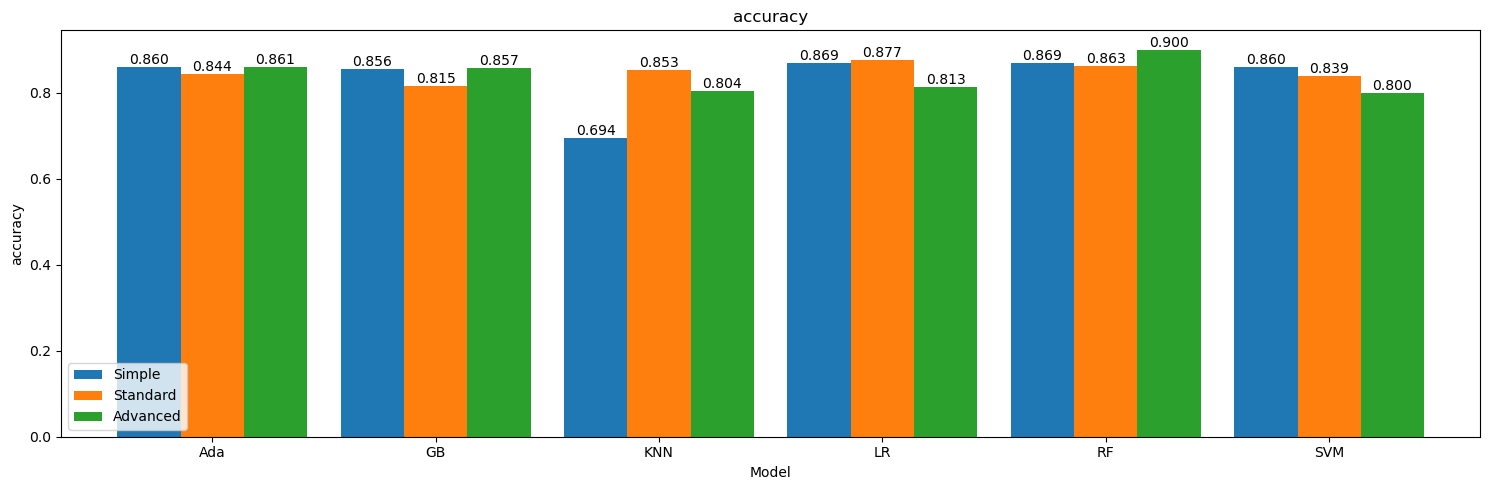

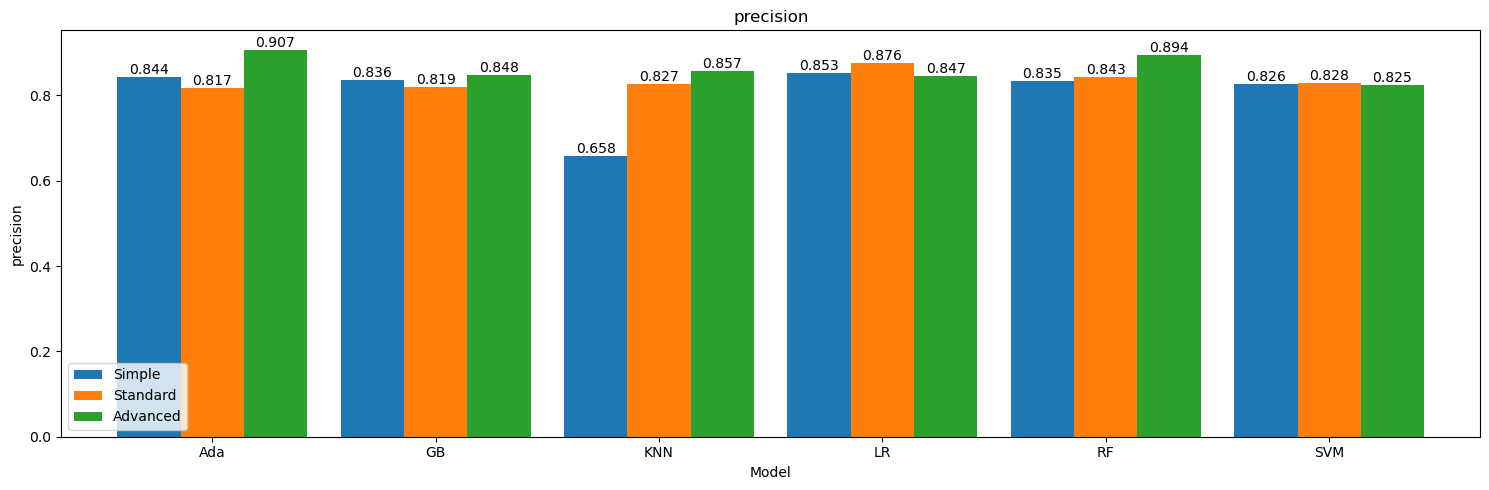

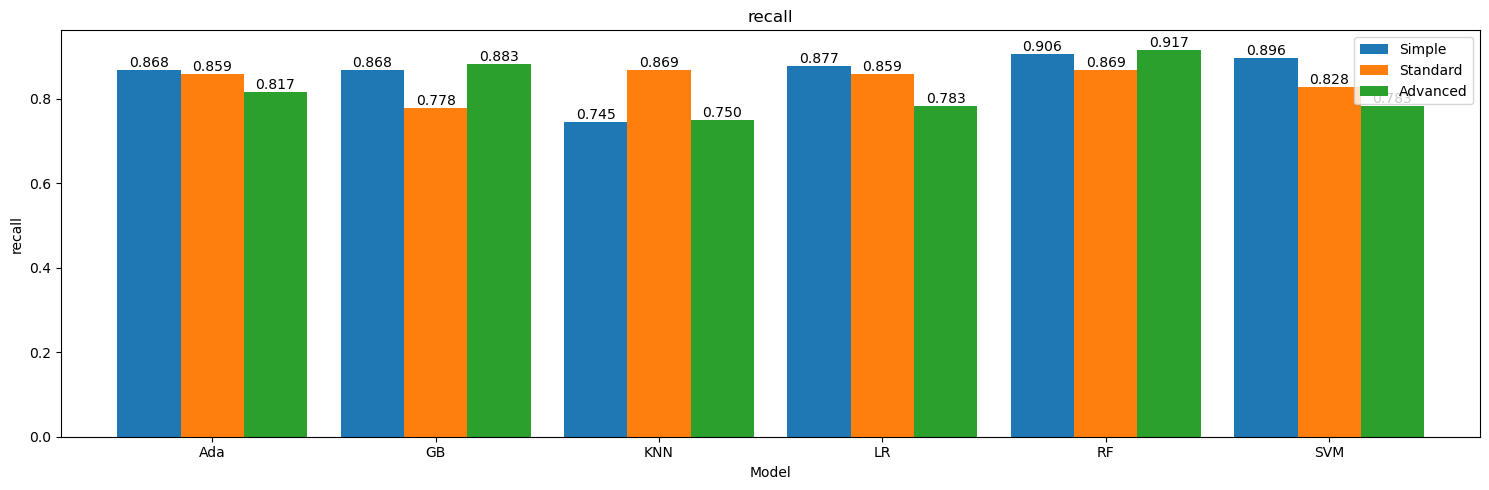

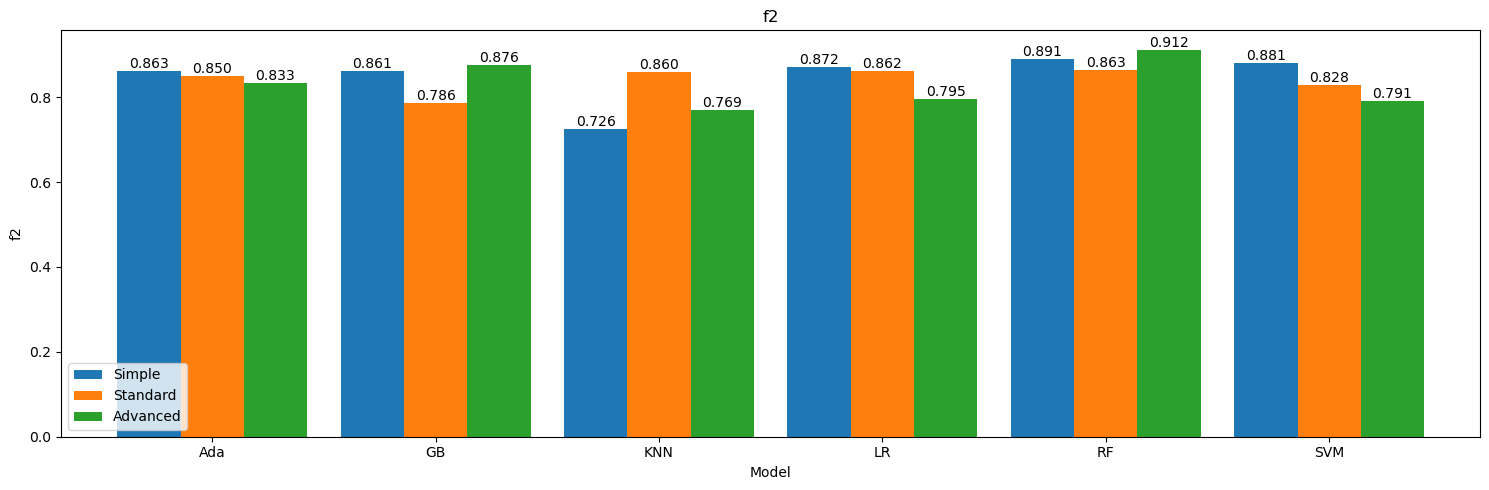

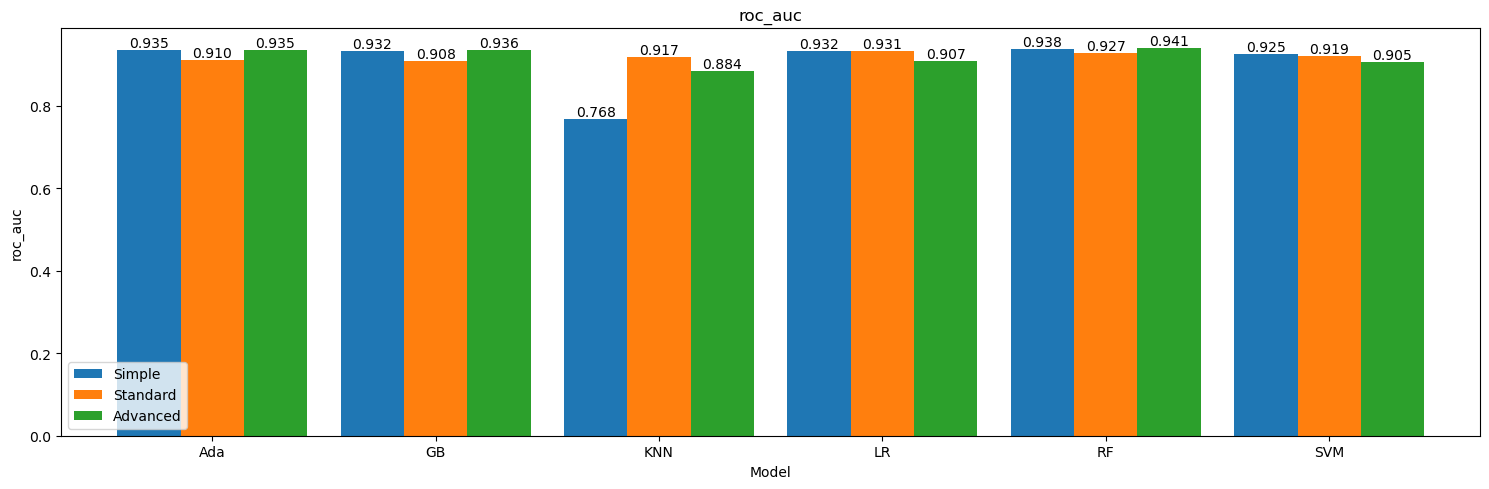

In [5]:
metrics = simple_metrics.columns.drop('model')

for metric in metrics:
    comparison = pd.DataFrame({
        'Model': simple_metrics['model'],
        'Simple': simple_metrics[metric],
        'Standard': standard_metrics[metric],
        'Advanced': advanced_metrics[metric]
    })
    comparison.set_index('Model', inplace=True)
    
    ax = comparison.plot(
        kind='bar',
        figsize=(15, 5),
        title=metric,
        width=0.85
    )
    ax.set_ylabel(metric)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f')

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

The bar charts confirm the conclusions drawn from the tables.
The highest Recall and F2 values were achieved by the Random Forest model with advanced preprocessing (Recall = 0.917, F2 = 0.912).
The lowest performance was observed in the KNN model with simple preprocessing (Recall = 0.745, F2 = 0.726).

#### Curve Analysis

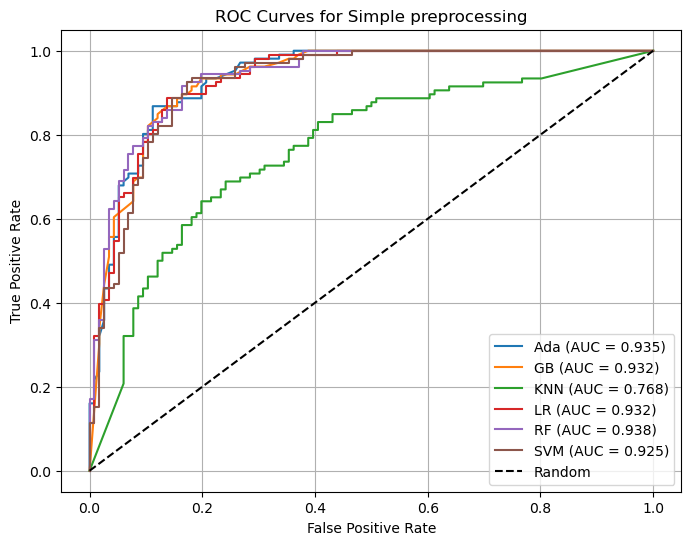

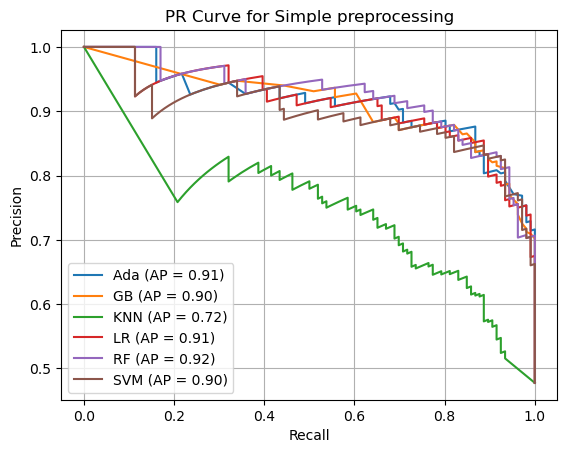

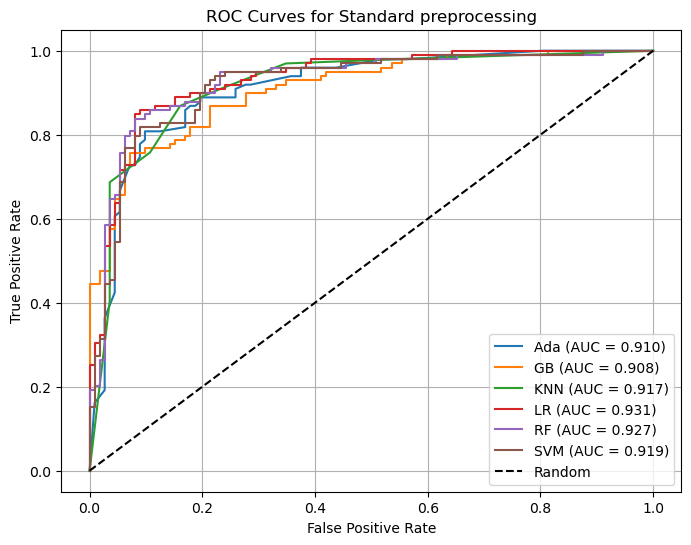

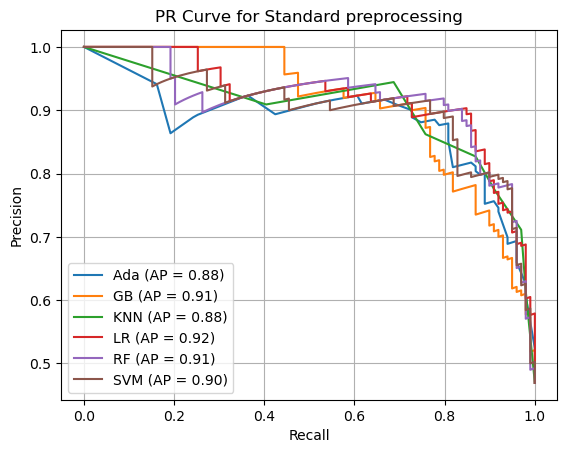

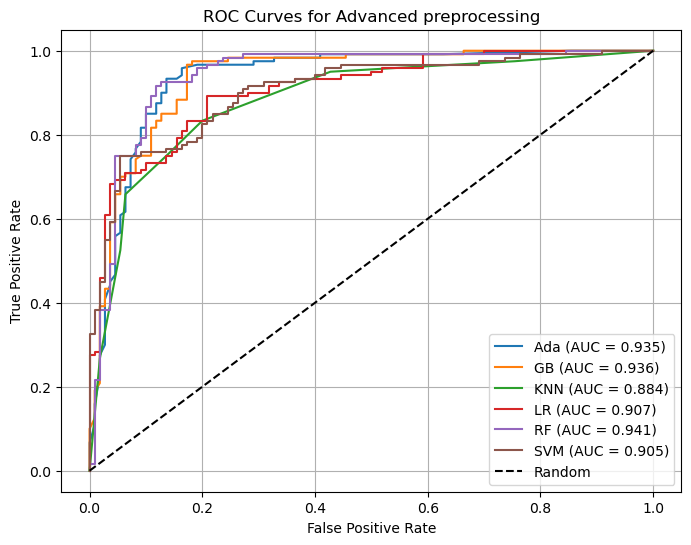

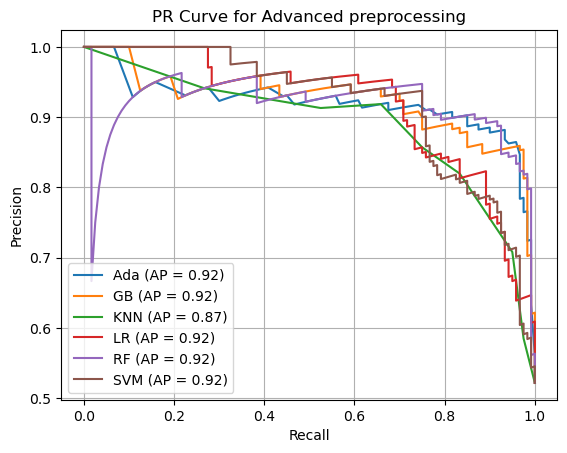

In [9]:
for prep in preprocessing_types:
    score_file = Path(results_dir / f'{prep}_y_scores.npy')
    metrics = Path(results_dir / f'{prep}_metrics.csv')
    df_metrics = pd.read_csv(metrics)

    y_scores = np.load(score_file, allow_pickle=True).item()
    y_test = pd.read_csv(splits_dir / f'{prep}_y_test.csv').values.ravel()

    plt.figure(figsize=(8,6))

    for model_name, y_score in y_scores.items():
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = df_metrics.loc[df_metrics['model'] == model_name, 'roc_auc'].values[0]
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")

    plt.plot([0,1], [0,1], 'k--', label="Random")

    plt.title(f"ROC Curves for {prep.capitalize()} preprocessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    for model_name, y_score in y_scores.items():
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)
        ap = average_precision_score(y_test, y_score)
        plt.plot(recall, precision, label=f"{model_name} (AP = {ap:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve for {prep.capitalize()} preprocessing")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

##### ROC Curve

**Simple preprocessing:**
All models except KNN reach TPR ≈ 1 at FPR ≈ 0.4, with AdaBoost, Gradient Boosting, and Random Forest rising slightly earlier than the others. The KNN model with simple preprocessing showed the lowest AUC = 0.768 and significantly lower TPR, making it the worst option among all pipelines.

**Standard preprocessing:**
The LR, KNN, RF, and SVM models reach TPR ≈ 1 approximately at FPR ≈ 0.65.

**Advanced preprocessing:**
Random Forest and Gradient Boosting reach TPR ≈ 1 already at FPR ≈ 0.25, with AdaBoost close to this value.

Therefore, for the task of detecting patients, the most relevant pipeline is Random Forest with advanced preprocessing, as this model achieves nearly full TPR at a relatively low FPR. Despite AdaBoost having a higher AUC, for practical purposes it is more critical that Random Forest detects more patients earlier.

##### PR Curve

The main objective is to find a balance between Recall and Precision such that Recall approaches 1, while Precision remains as high as possible.

**Simple preprocessing:**

The AdaBoost model demonstrates the best performance under simple preprocessing. When Recall reaches 1, Precision remains at approximately 0.7.
With only a small difference, Gradient Boosting and Random Forest show comparable Precision–Recall behavior. The worst performance is observed for KNN. When Recall equals 1, Precision drops below 0.5, indicating that a large proportion of patients are falsely classified as sick. This model also has the lowest Average Precision (AP = 0.72) among all considered pipelines.

**Standard preprocessing:**

With standard preprocessing, a general degradation of PR curve behavior is observed. All models reach Recall = 1 at relatively low Precision values (around 0.5), suggesting that the classifiers operate close to random guessing when maximizing Recall. Among all models, Logistic Regression performs slightly better, achieving Precision of approximately 0.6 at Recall = 1, which is the best result within this preprocessing setting.

**Advanced preprocessing:**

The best performance is achieved by Random Forest and Gradient Boosting. These models reach Recall close to 1 while maintaining Precision around 0.8, or Recall ≈ 0.9 with Precision ≈ 0.85, representing the most favorable Precision–Recall trade-off across all experiments. However, Random Forest shows less stable behavior in the early part of the PR curve, which may indicate the need for probability calibration, whereas Gradient Boosting demonstrates more consistent performance. The KNN model again shows the weakest performance across all metrics.

ROC AUC can appear optimistic on imbalanced datasets, while PR curves provide a more informative evaluation by focusing on the positive class.

## Summary